<h1> DATA CLEANING </h1>

In [289]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np

%matplotlib inline

In [290]:
df = pd.read_csv("./clean_data.csv")
df = df.rename(columns={"Unnamed: 0": "index"})
df = df.set_index("index")
df.columns

Index(['type', 'subtype', 'price', 'postalCode', 'locality', 'condition',
       'facadeCount', 'isFurnished', 'bedroomCount', 'netHabitableSurface',
       'kitchen', 'hasTerrace', 'terraceSurface', 'hasGarden', 'gardenSurface',
       'hasSwimmingPool', 'fireplaceExists'],
      dtype='object')

In [291]:
for column in df.columns.to_list():
    df[column] = df[column].apply(lambda x:int(eval(x)) if x in ['True', 'False'] else x)
    df[column] = df[column].apply(lambda x:int(x) if x in [True, False] else x)


df.drop(df[df.subtype == 'APARTMENT_BLOCK'].index, axis=0, inplace=True)
df.drop(['terraceSurface', 'gardenSurface', "isFurnished", 'facadeCount'], axis=1, inplace=True)

df.loc[df.kitchen.isin(['USA_SEMI_EQUIPPED', 'USA_UNINSTALLED']), 'kitchen'] = 0
df.rename(columns={'kitchen':'full_kitchen'}, inplace=True)

features = ['type', 'subtype', 'price', 'postalCode', 'condition', 'bedroomCount', 'netHabitableSurface']
df.drop_duplicates(subset=features, inplace=True)

df.dropna(subset=['price'], inplace=True)
df.dropna(subset=['netHabitableSurface'], inplace=True)
# df.dropna(subset=['condition'], inplace=True)
# df.dropna(subset=['full_kitchen'], inplace=True)

for column in ['hasTerrace','hasGarden', 'full_kitchen', 'hasSwimmingPool']:
    df[column].fillna(0, inplace=True)
df = df.astype({'hasTerrace': int, 'hasGarden': int, 'full_kitchen': int})

type_binary = {'HOUSE': 1,
               'APARTMENT': 0}

df.type = df.type.apply(lambda x:type_binary[x])


In [292]:
codes = (("Brussels Capital Region", 1000, 1299),
          ("Walloon Brabant", 1300, 1499),
          ("Flemish Brabant", 1500, 1999),
          ("Antwerp", 2000, 2999),
          ("Flemish Brabant", 3000, 3499),
          ("Limburg", 3500, 3999),
          ("Liege", 4000, 4999),
          ("Namur", 5000, 5999),
          ("Hainaut", 6000, 6599),
          ("Luxembourg", 6600, 6999),
          ("Hainaut", 7000, 7999),
          ("West Flanders", 8000, 8999),
          ("East Flanders", 9000, 9999))

def find_province(postalCode):
    for _tuple in codes:
        if _tuple[1] <= postalCode <= _tuple[2]:
            return _tuple[0]
    return np.nan

province = df.postalCode.apply(find_province)
df['Province'] = province

In [293]:
# Here, we are getting rid of postalCode with too few data points
postalcodes = df.groupby(['postalCode']).count().query("type > 10").index

In [294]:
df = df[df.postalCode.isin(postalcodes)]
len(df)

12123

## Machine Learning

In [295]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import power_transform
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats

In [296]:
s = df.postalCode
codes = pd.get_dummies(s, drop_first=True)
df.drop(['postalCode', 'locality'], axis=1, inplace=True)
codes.shape

(12123, 325)

In [297]:
s = df.subtype
subtypes = pd.get_dummies(s, drop_first=True)
df.drop(['subtype'], axis=1, inplace=True)
subtypes.shape

(12123, 21)

In [298]:
s = df.Province
provinces = pd.get_dummies(s, drop_first=True)
df.drop(['Province'], axis=1, inplace=True)
provinces.shape

(12123, 10)

In [299]:
belgium = pd.concat([df, provinces], axis=1)

# Not using some of the features
belgium.drop(['condition', 'fireplaceExists'], axis=1, inplace=True)

In [300]:
# belgium = belgium[(np.abs(stats.zscore(belgium['price'])) < 3)]
# belgium = belgium[(np.abs(stats.zscore(belgium['bedroomCount'])) < 3)]

# Getting rid of future outliers when using log-values
belgium = belgium.sort_values('price').iloc[9:-10,:]

price = np.array(belgium.price)
data = belgium.drop('price', axis=1)

In [301]:
print(len(belgium))
belgium.sort_values('price').head(10)

12104


,type,price,bedroomCount,netHabitableSurface,full_kitchen,hasTerrace,hasGarden,hasSwimmingPool,Brussels Capital Region,East Flanders,Flemish Brabant,Hainaut,Liege,Limburg,Luxembourg,Namur,Walloon Brabant,West Flanders
index,,,,,,,,,,,,,,,,,,
7604,1,30000.0,2.0,80.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0
16790,0,30000.0,2.0,110.0,1,1,0,0.0,0,0,0,0,1,0,0,0,0,0
7665,1,39000.0,2.0,47.0,0,1,1,0.0,0,0,0,0,0,0,0,1,0,0
274,1,40000.0,3.0,138.0,0,0,1,0.0,0,0,0,1,0,0,0,0,0,0
7191,1,40000.0,5.0,165.0,0,0,1,0.0,0,0,0,0,1,0,0,0,0,0
3917,1,40000.0,2.0,155.0,0,0,0,0.0,0,0,0,1,0,0,0,0,0,0
17847,0,40000.0,1.0,24.0,0,0,0,0.0,0,0,0,0,0,0,0,1,0,0
9030,1,41922.0,1.0,40.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0
12287,0,45000.0,1.0,43.0,1,0,0,0.0,0,0,0,1,0,0,0,0,0,0


In [302]:
y_box = np.ravel(power_transform(price.reshape(-1, 1), method='box-cox'))
y = price
y_log = np.log(price)
X = data
X.head()

,type,bedroomCount,netHabitableSurface,full_kitchen,hasTerrace,hasGarden,hasSwimmingPool,Brussels Capital Region,East Flanders,Flemish Brabant,Hainaut,Liege,Limburg,Luxembourg,Namur,Walloon Brabant,West Flanders
index,,,,,,,,,,,,,,,,,
7604,1,2.0,80.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0
16790,0,2.0,110.0,1,1,0,0.0,0,0,0,0,1,0,0,0,0,0
7665,1,2.0,47.0,0,1,1,0.0,0,0,0,0,0,0,0,1,0,0
274,1,3.0,138.0,0,0,1,0.0,0,0,0,1,0,0,0,0,0,0
7191,1,5.0,165.0,0,0,1,0.0,0,0,0,0,1,0,0,0,0,0


In [303]:
scaler = RobustScaler()

In [304]:
model = RandomForestRegressor(random_state=0)

In [305]:
Kfolds = RepeatedKFold(n_splits=5, n_repeats=1, random_state=21)

In [306]:
def my_pipe(scaler, model, Kfolds, X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    params_en = {
        'min_samples_split' : [8, 10],
        'max_features' : ['log2']
    }

    results = GridSearchCV(model, param_grid=params_en, cv=Kfolds, scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'], n_jobs=-1, verbose=1, refit='r2').fit(X_train, y_train)
    y_predict = results.predict(X_test)

    print(results.best_score_, results.best_params_)
    
    adj_R2 = 1-(1-r2_score(y_test, y_predict))*((len(X_test)-1)/(len(X_test)-len(X_test[0])-1))
    
    print(r2_score(y_test, y_predict), adj_R2)

    sns.residplot(x=y_test, y=y_predict)
    
    return results

Fitting 5 folds for each of 2 candidates, totalling 10 fits
0.5591578856537567 {'max_features': 'log2', 'min_samples_split': 8}
0.5726132756952186 0.5701978587028047


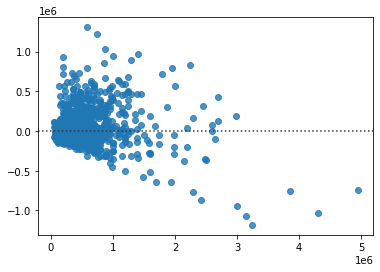

In [307]:
results_nolog = my_pipe(scaler, model, Kfolds, X, y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
0.6351426636742572 {'max_features': 'log2', 'min_samples_split': 10}
0.6273315269410813 0.6252253553845648


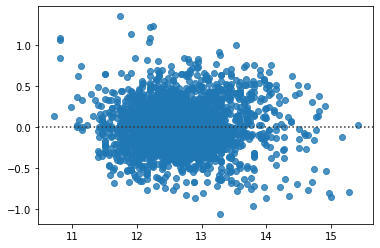

In [308]:
results = my_pipe(scaler, model, Kfolds, X, y_log)

As we can see, training the RandomForestRegressor on the target leads to a residual plot with a noticeable heteroscedasticity; using the log of the target removes the increasing correlated variance, and improves the r2 score. The score is still quite low, but that is probably due to either: 
1) Issues during the scraping (some values were not properly gathered and the dataset is not good enough)
2) Issues in the cleaning (either too many rows or features were dropped, or some inferences for value replacement were not valid)
3) Issues stemming from features interacting with one another (bedroomCount and netHabitableSurface for instance).

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
y_predict = results.predict(X_test)

[0.00463176 0.09309391 0.86958789 0.00601828 0.00845274 0.0065643
 0.0049734  0.00667771]


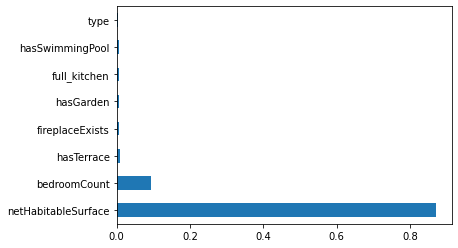

In [153]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
X = df.copy()
y = np.array(X.price)
X.drop(['price', 'condition'], axis=1, inplace=True)
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [154]:
X = belgium[['netHabitableSurface']]
y = belgium.price

In [155]:
X

,netHabitableSurface
index,
7604,80.0
16790,110.0
7665,47.0
274,138.0
7191,165.0
...,...
10319,252.0
9932,163.0
5589,450.0


0.34101847010147934


<AxesSubplot:xlabel='price'>

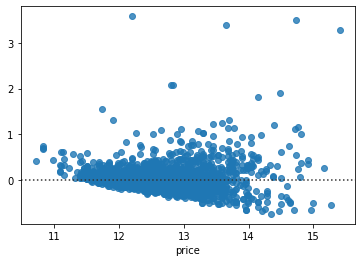

In [156]:
regressor = LinearRegression()


X_train, X_test, y_train, y_test = train_test_split(X, np.log(y), test_size=0.25, random_state=0)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

regressor.fit(X_train,y_train)

y_predict = regressor.predict(X_test)

print(r2_score(y_test, y_predict))


sns.residplot(x=y_test, y=y_predict)